# Regularization
![](https://doc.plob.org/machine_learning/07_Regularization_files/Image.png)
![](https://www.globalsoftwaresupport.com/wp-content/uploads/2018/02/lkklk888.png)

**Table of Content:** <br/>
This notebook is an illustration of how **regularized linear models** work, using the house prices **training** set. <br/>

* Single-variable models (for illustration purposes)
    * Ridge regression
    * Lasso regression
    * Elastic net
* Multi-variable models
    * Elastic net
    * SGD and early stopping (with k-fold splitting)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import os
import warnings
warnings.filterwarnings("ignore")
print(os.listdir("input/Lecture_04_3/"))

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
plt.rc('axes', lw = 1.5)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('xtick.major', size = 5, width = 3)
plt.rc('ytick.major', size = 5, width = 3)

We will first choose just one independent variable for visualization purpose, and try out different regularized linear models. Later we will expand the models to multiple independent variables.

In [3]:
# open the training dataset
dataTrain = pd.read_csv('input/Lecture_04_3/train.csv')
dataTrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#We will focus only on numeric features here. 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
dataTrain = dataTrain.select_dtypes(include=numerics)
dataTrain.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


# Single Variable Models (for illustration purposes)
**We simplify the data for the purpose of illustration and introduction of the regularized models. **  
Later we will include multiple variables in the models.

In [5]:
dataTrain = dataTrain[['GarageArea','SalePrice']]
dataTrain.head()

,GarageArea,SalePrice
0,548,208500
1,460,181500
2,608,223500
3,642,140000
4,836,250000


Check to see if there are any missing values?

In [6]:
dataTrain.isnull().values.any()

False

No missing values, so we don't have to worry much about data cleaning.

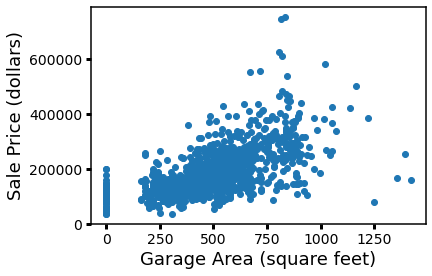

In [7]:
# Take a look at the data. 
plt.plot('GarageArea','SalePrice',data=dataTrain, marker = 'o', linestyle = '')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.show()

In [8]:
# format training data
xTrain = dataTrain['GarageArea'].values.reshape(-1,1) # as_matrix is deprecated since version 0.23.0
yTrain = dataTrain['SalePrice'].values.reshape(-1,1)
xTrain

array([[548],
       [460],
       [608],
       ...,
       [252],
       [240],
       [276]], dtype=int64)

Let's first do a degree 10 linear regression model **without** regularization.

In [9]:
# Transform the input features
Poly = PolynomialFeatures(degree = 10, include_bias = False)
xTrainPoly = Poly.fit_transform(xTrain)

we standardize input features through **Scikit-learn**:

In [10]:
from sklearn.preprocessing import StandardScaler
# standardization
scaler = StandardScaler()
xTrainPolyStan = scaler.fit_transform(xTrainPoly)
scaler.scale_, scaler.mean_

(array([2.13731608e+02, 2.24211273e+05, 2.32893337e+08, 2.57524995e+11,
        3.06990248e+14, 3.88489528e+17, 5.11049967e+20, 6.87865895e+23,
        9.38340778e+26, 1.29044368e+30]),
 array([4.72980137e+02, 2.69391410e+05, 1.72384828e+08, 1.22842427e+11,
        9.68455771e+13, 8.39558350e+16, 7.94695046e+19, 8.14093850e+22,
        8.92902055e+25, 1.03622078e+29]))

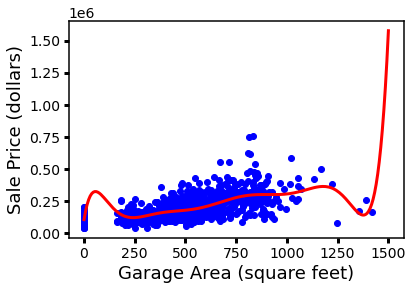

In [11]:
# linear regression
reg = LinearRegression()
reg.fit(xTrainPolyStan, yTrain)

# predict
xFit = np.linspace(0,1500,num=200).reshape(-1,1)
xFitPoly = Poly.transform(xFit)
xFitPolyStan = scaler.transform(xFitPoly)
yFit = reg.predict(xFitPolyStan)

# plot
plt.plot(xFit,yFit, lw=3, color='r', zorder = 2)
plt.plot('GarageArea','SalePrice',data=dataTrain, marker = 'o', color = 'b', linestyle = '', zorder = 1)
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.show()

# Adding Regularization Term
![](https://laid.delanover.com/wp-content/uploads/2018/01/reg_formulas.png)

![](https://www.researchgate.net/profile/Frank_Emmert-Streib/publication/330380054/figure/tbl2/AS:715185664823298@1547524958338/Overview-of-regularization-or-penalty-terms-and-methods-utilizing-them.png)

## Ridge Regression
Regular linear regression has the form of: <br>$J(\theta) = MSE(\theta)$ </br>

Ridge regression appy a regularization term proportional to the **square of L2-norm** of feature weights (not including the intercept). A common expression is: 
<br>
$J(\theta) = MSE(\theta) + \frac{\alpha}{2} (\theta_1^2 + \theta_2^2 + ... + \theta_n^2)$
</br>

The corrsponding expression for gradient of theta and the optimal solution for theta will change, due to the additonal term. We can also use the **Scikit-Learn** package to do ridge regression.

In [12]:
from sklearn.linear_model import Ridge

Ridge regression is sensitive to the input features, therefore **standardization is usually recommended** before Ridge regression. <br/>
Some useful info here: https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression <br/>
Here, standardization has already been carried out (see above), so we will go straight to training.

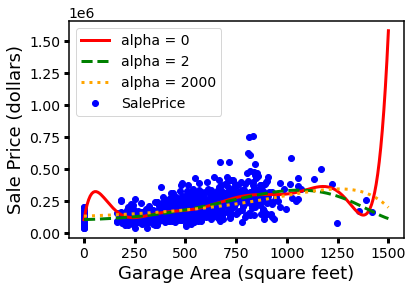

In [13]:
i=0
ls = ['-','--',':']
color = ['r','g','orange']

for a in [0,2,2000]:
    ridgeReg = Ridge(alpha=a)
    ridgeReg.fit(xTrainPolyStan, yTrain)

    # predict
    xFit = np.linspace(0,1500,num=200).reshape(-1,1)
    xFitPoly = Poly.transform(xFit)
    xFitPolyStan = scaler.transform(xFitPoly)
    yFit = ridgeReg.predict(xFitPolyStan)
    
    # plot
    plt.plot(xFit,yFit, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1
    
plt.plot('GarageArea','SalePrice',data=dataTrain, marker = 'o', color = 'b', linestyle = '', zorder = 1)
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()

In general, **the larger alpha is, the "flatter" the fit will be**. Eventually, as alpha approaches infinity, the prediction y_hat will just be a constant, since all thetas (except the intercept) will be regularized to zero.  
In theory, **Ridge regression** with alpha = 0 should give the same result as regular linear regression, but sometimes that is not the case. See one post here: https://stackoverflow.com/questions/40570370/difference-between-linearregression-and-ridgealpha-0.  
The post describes a polynomial model where Ridge regression overflowed, but linear regression did not. (we don't have this problem here.)

## Lasso Regression
Least Absolute Shrinkage and Selection Operator Regression - LASSO  
$Cost function: J(\theta) = MSE(\theta) + alpha (|\theta_1| + |\theta_2| + ... + |\theta_n|)$

The penalty is proportional to the **L1-norm** of theta. 

* The advantage of **Lasso** over **Ridge regression** lies in the **diamond shape** of contour of the **L1-norm** penalty, which leads to some of the thetas being eliminated (set to 0) quickly.  
* This means the Lasso regression can perform automatic feature selection, when ridge regression cannot. 
* You can also understand the difference of Ridge and Lasso regression by understanding that, Ridge's L2-penalty heavily penalizes large thetas, but has nearly no penalization for small thetas (due to the square), whereas Lasso's l1-penalty gives appropriate penalization to even small thetas.  
![](https://miro.medium.com/max/427/1*UiLesmZjRH6xY1V6UMFClw.png)

In [14]:
from sklearn.linear_model import Lasso

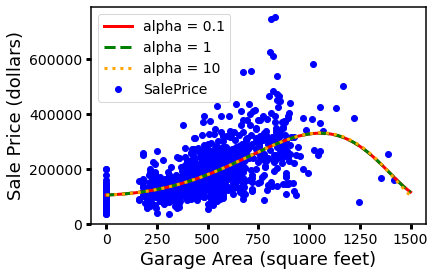

In [15]:
i=0
ls = ['-','--',':']
color = ['r','g','orange']

for a in [0.1,1,10]:
    lassoReg = Lasso(alpha=a)
    lassoReg.fit(xTrainPolyStan, yTrain)

    # predict
    xFit = np.linspace(0,1500,num=200).reshape(-1,1)
    xFitPoly = Poly.transform(xFit)
    xFitPolyStan = scaler.transform(xFitPoly)
    yFit = lassoReg.predict(xFitPolyStan)
    
    # plot
    plt.plot(xFit,yFit, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1
    
plt.plot('GarageArea','SalePrice',data=dataTrain, marker = 'o', color = 'b', linestyle = '', zorder = 1)
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()

As you can see, the three alpha tested gives very similar fits. As mentioned earlier, Lasso regression tends to return sparse theta vector, with many least important features eliminated (set to 0). Even when alpha is small, such elimination can happen, leading to similar fits for certain range of alphas.

As mentioned in Scikit-Learn's [documentaion](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), Lasso function is not advised to use with alpha = 0. In such cases, LinearRegression should be used instead. <br/>

**Stochastic gradient descent** can be used for any type of optimization problem.  
Here we show the example of **Lasso regression using SGDRegressor** from Scikit-Learn package.

In [16]:
from sklearn.linear_model import SGDRegressor

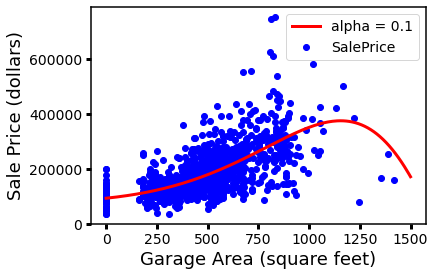

In [17]:
sgd = SGDRegressor(loss='squared_loss', penalty='l1', alpha=0.1)
yTrain = yTrain.ravel() # format required by sgd
sgd.fit(xTrainPolyStan, yTrain)

# predict
xFit = np.linspace(0,1500,num=200).reshape(-1,1)
xFitPoly = Poly.transform(xFit)
xFitPolyStan = scaler.transform(xFitPoly)
yFit = sgd.predict(xFitPolyStan)

plt.plot(xFit,yFit, lw=3, color='r', zorder = 2, label= "alpha = 0.1",linestyle='-')
plt.plot('GarageArea','SalePrice',data=dataTrain, marker = 'o', color = 'b', linestyle = '', zorder = 1)
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()

## Elastic Net
Elastic net is somewhere between ridge regression and lasso regression. The cost function is: 
<br>
$J(\theta) = MSE(\theta) + r\cdot lasso\_penalty + (1-r)\cdot ridge\_penalty. $
</br>

![](https://hackernoon.com/hn-images/1*gAmw-_z6v4bG9HcnPSAK3Q.png)
![](https://cdn-images-1.medium.com/max/1200/0*kuuC8_3Q2YjoLoqt.png)

In [18]:
from sklearn.linear_model import ElasticNet

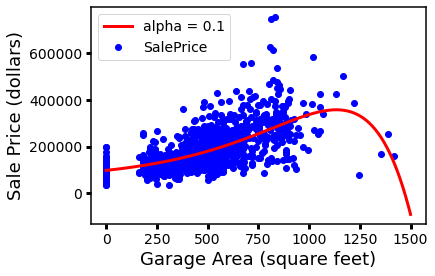

In [19]:
yTrain = yTrain.reshape(-1,1)
elasticReg = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elasticReg.fit(xTrainPolyStan, yTrain)

# predict
xFit = np.linspace(0,1500,num=200).reshape(-1,1)
xFitPoly = Poly.transform(xFit)
xFitPolyStan = scaler.transform(xFitPoly)
yFit = elasticReg.predict(xFitPolyStan)

plt.plot(xFit,yFit, lw=3, color='r', zorder = 2, label= "alpha = 0.1",linestyle='-')
plt.plot('GarageArea','SalePrice',data=dataTrain, marker = 'o', color = 'b', linestyle = '', zorder = 1)
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()

**So, which model should we choose in practice?** <br/>
Ridge regression: a good default. However, if sparse features are expected, ridge should be replaced by lasso or elastic net. <br/>
Lasso regression: good for sparse feature selection. However, if the number of features is greater than the number of training samples, or when there are strongly correlated features, ridge or elastic net should be used. <br/>
Elastic net: versatile since the ratio parameter r is tunable. A 50% ratio of l1 and l2-penalty can be a good default, too.

# Multi-variable models (for actual prediction)
Here, we try to predict house prices with an elastic net model with fourth order features. <br/>
Let's look at the training set again:



In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
dataTrain = pd.read_csv('input/Lecture_04_3/train.csv')
dataTrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Let's say we have reasons to believe the OverallQual, LotArea, TotalBsmtSF, 1stFlrSF, 2ndFlrSF,  GarageArea, and OpenPorchSF are some of the most relevant features for sale price prediction, and we want to build a four-degree (including interactions) linear model with elastic net regularization to predict sale price (**this is, of course, a huge simiplification of the actual problem, but here we just want to show how the regularized linear models work, and how well they can perform with limited information** ). Here is how we do it:

In [22]:
# Obtain training data
xTrain = dataTrain[['OverallQual','LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'OpenPorchSF']].values
yTrain = dataTrain['SalePrice'].values.reshape(-1,1)

## Elastic Net

In [23]:
# Transform the data
poly2 = PolynomialFeatures(degree = 4, include_bias = False)
xTrainPoly = poly2.fit_transform(xTrain)
scaler = StandardScaler()
xTrainPolyStan = scaler.fit_transform(xTrainPoly)

# Fit the data
elasticReg = ElasticNet(alpha = 0.1, l1_ratio = 0.85)
elasticReg.fit(xTrainPolyStan, yTrain)

# evaluate performance on training set
yTrainHat = elasticReg.predict(xTrainPolyStan)

# calculate rmse based on log(price)
mse = mean_squared_error(np.log(yTrain), np.log(yTrainHat))
rmse = np.sqrt(mse)
print(rmse)

0.152314810652


 Let's plot predicted sale price and actual sale price:

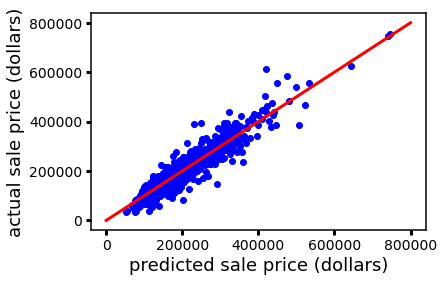

In [24]:
x = np.linspace(0,800000,num=1000)
plt.plot(yTrainHat, yTrain,marker='o', linestyle = '', zorder = 1, color='b')
plt.plot(x, x, linestyle = '-',color='red',zorder=2,lw=3)
plt.xlabel('predicted sale price (dollars)', fontsize = 18)
plt.ylabel('actual sale price (dollars)', fontsize = 18)
plt.show()

Not bad. Let's try the test set.

In [25]:
dataTest = pd.read_csv('input/Lecture_04_3/test.csv')
dataTest.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [26]:
dataTest = dataTest[['Id','OverallQual','LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea','OpenPorchSF']]
dataTest.isnull().any()

Id             False
OverallQual    False
LotArea        False
TotalBsmtSF     True
1stFlrSF       False
2ndFlrSF       False
GarageArea      True
OpenPorchSF    False
dtype: bool

In [27]:
# fill the nans with respective means.
dictMs = {'TotalBsmtSF':dataTest['TotalBsmtSF'].mean(skipna=True),
          'GarageArea':dataTest['GarageArea'].mean(skipna=True)}
dataTest = dataTest.fillna(value=dictMs)
dataTest.isnull().any()

Id             False
OverallQual    False
LotArea        False
TotalBsmtSF    False
1stFlrSF       False
2ndFlrSF       False
GarageArea     False
OpenPorchSF    False
dtype: bool

In [28]:
xTest = dataTest[['OverallQual','LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'OpenPorchSF']].values
xTestPoly = poly2.transform(xTest)
xTestPolyStan = scaler.transform(xTestPoly)
yTestHat = elasticReg.predict(xTestPolyStan)